In [1]:
import surprise
from surprise import BaselineOnly, Dataset, KNNBasic, KNNBaseline, NormalPredictor, SVD, SlopeOne, NMF, SVDpp, KNNWithMeans, KNNWithZScore, CoClustering
from surprise import accuracy, evaluate, Reader, model_selection
import utils

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, log_loss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import os
import json
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
%ls

AbstractBaseCollabFilterSGD.py*    model_params/
CollabFilterMeanOnly.py*           plots/
CollabFilterMeanOnly.py~*          Project systems updated.pdf
CollabFilterOneScalarPerItem.py*   __pycache__/
CollabFilterOneScalarPerItem.py~*  recommendation.ipynb
CollabFilterOneVectorPerItem.py*   requirements.txt*
CollabFilterOneVectorPerItem.py~*  select_movies/
data_movie_lens_100k/              test_preds/
Introduction_Autograd.ipynb*       utils.py*


### Part 1 - Simple Baseline Model with SGD and autograd
As a part of this model, we are guessing constant rating for each of user and movie id combinations. We'll be predicting same value for each combinations. We'll try to find out optimal value of this prediction $\mu$ so that Mean Absolute Error is less as much as possible.

#### Epochs vs MAE for train & validation sets
<img src='plots/M1.png' style='width:600px;height:600px;'>

**Regularization:** Adding regularization is not helping much to improve performance. We tried adding L2 regularization based on parameter $\mu$.

**Performance Without adding reguarization:**

* Train MAE : `0.941`
* Validation MAE : `0.943`

**Performance adding L2 reguarization:**

* Train MAE : `0.941`
* Validation MAE : `0.943`

**Best Score $\mu$ :** `3.54`

**Clsoed Form Solution :** One can also take `mean` of trainset ratings and guess it as rating for each test set combinations. It won't require to use SGD at all. Average rating on train set is `3.53` which matches with results of SGD.

### Part 2 : One Scaler Per Item Baseline with SGD and autograd
We are using one scaler per user and one scaler per movie for this model. We then optimize this scalers for each movie and user through training and evaluating as MAE.

#### Epochs vs MAE for train and validation set
<img src='plots/M2.png' style='width:600px;height:600px;'>

`M2` model is quite an improvement in terms of performance from `M1` model as it guesses different ratings for each `(user_id, movie_id)` combinations whereas `M1` guesses same rating for each combinations.

* Train MAE : `0.727`
* Validation MAE : `0.744`

**Best Params** : Please refer to file `M2.json` under folder `model_params` for getting idea about model's trained parameters.

#### Select Movies Examination
We have saved `c_per_item` parameter for selected set of movies saved in `select_movies.csv` file.

We have noticed that `Animation/Cartoon/Horror` movies (Toy Story, Lion King, Scream etc) has very `negative` values for parameter `c` whereas `scifi/adventure` movies (Empire Strikes Back, Snow White and Seven Dwarves) has quite `high` values for paramer `c`. Romantic comedy movie like Sleepless in Seattle (1993)	also has quite high value for parameter `c`.

In [3]:
pd.read_csv('select_movies/M2_select_movies_c_param.csv')

,item_id,title,release_year,orig_item_id,c_parameter
0,0,Toy Story (1995),1995,1,-0.017818
1,70,"Lion King, The (1994)",1994,71,-0.083676
2,98,Snow White and the Seven Dwarfs (1937),1937,99,0.807818
3,131,"Wizard of Oz, The (1939)",1939,132,0.501377
4,142,"Sound of Music, The (1965)",1965,143,0.565982
5,49,Star Wars (1977),1977,50,0.086464
6,171,"Empire Strikes Back, The (1980)",1980,172,0.832206
7,180,Return of the Jedi (1983),1997,181,0.615166
8,81,Jurassic Park (1993),1993,82,0.704766
9,251,"Lost World: Jurassic Park, The (1997)",1997,252,0.153030


### Part 3 : Matrix Factorization using SGD and autograd
As part of this we will be trying various models with five matrix factorization parameters. ($\mu$, $b_i$, $c_i$, $u_i$ K dimensional vector for user i, $v_i$ - K dimensional vector for movie i)

We'll try various values for factors length for each user and movie. We'll also try various regularization penalties on this model to find out best model.

#### K = 2 and No Regularization:
<img src='plots/M3_1.png' style='width:600px;height:600px;'>

#### K = 10 and No Regularization:
<img src='plots/M3_5.png' style='width:600px;height:600px;'>

#### K = 50 and No Regularization:
<img src='plots/M3_9.png' style='width:600px;height:600px;'>

#### K = 2 and Regularization = 0.001:
<img src='plots/M3_2.png' style='width:600px;height:600px;'>

#### K = 10 and Regularization = 0.001:
<img src='plots/M3_6.png' style='width:600px;height:600px;'>

#### K = 50 and Regularization = 0.001:
<img src='plots/M3_10.png' style='width:600px;height:600px;'>

#### K = 2 and Regularization = 0.01:
<img src='plots/M3_3.png' style='width:600px;height:600px;'>

#### K = 10 and Regularization = 0.01:
<img src='plots/M3_7.png' style='width:600px;height:600px;'>

#### K = 50 and Regularization = 0.01:
<img src='plots/M3_11.png' style='width:600px;height:600px;'>

#### K = 2 and Regularization = 0.1:
<img src='plots/M3_4.png' style='width:600px;height:600px;'>

#### K = 10 and Regularization = 0.1:
<img src='plots/M3_8.png' style='width:600px;height:600px;'>

#### K = 50 and Regularization = 0.1:
<img src='plots/M3_12.png' style='width:600px;height:600px;'>

**Best Performance:**

* Train MAE : `0.723`
* Valid MAE : `0.753`

**Best Params:**

* n_factors : `2` , alpha = `0.1`

Please check file `M3_4.json` for checking parameter values for this best performing model for this part.

After trying various parameters and penalty values we have found out that above mentioned parameter settings give best results.

Our current model `M3` performs quite bettern than `M1` and little better than `M2`.We tried various vaues for n_factors like `2, 10, 50` and found out that value of 2 gives best results. Trying more than 50 parameter might not give good results as we have model which give good results for `n_factors = 2` and we tried bigger values than tha like 10,50 which did not give good results than it. Hence we don't recommend trying more than 50 for n_factors.

#### Select Movies Examination
We have found out select movies embedding parameters `V` for movies with `K = 2` and `alpha = 0.1`. We'll plot it as scatter plot.

We can see that Adventure/Scifi movies(Return of Jedi, Indiana Jones, Star Wars etc) has values which are quite around zero and right in graph.

Cartoon/Horror/Animation movies(Lion King, Scream etc) has high positive/negative values for V2 and less value for V1. We can notice that all Adventure/Scifi are gathered around 0 in center and Horror/Cartoon/romantic movies are spread.

<img src='select_movies/M3_4.png' style='width:600px;height:600px;'>

In [4]:
pd.read_csv('select_movies/M3_select_movies_V_4.csv')

,item_id,title,release_year,orig_item_id,V
0,0,Toy Story (1995),1995,1,[ 0.55649435 -0.03255801]
1,70,"Lion King, The (1994)",1994,71,[-0.23377262 0.44090488]
2,98,Snow White and the Seven Dwarfs (1937),1937,99,[ 0.09000491 -0.08183166]
3,131,"Wizard of Oz, The (1939)",1939,132,[ 0.19693762 -0.29926128]
4,142,"Sound of Music, The (1965)",1965,143,[-0.25358477 -0.28140179]
5,49,Star Wars (1977),1977,50,[0.10592744 0.05422478]
6,171,"Empire Strikes Back, The (1980)",1980,172,[ 0.00340893 -0.01312453]
7,180,Return of the Jedi (1983),1997,181,[0.34272096 0.12824491]
8,81,Jurassic Park (1993),1993,82,[-0.43722235 -0.05117469]
9,251,"Lost World: Jurassic Park, The (1997)",1997,252,[ 0.50879849 -0.46065543]


### Part 4 : Matrix Factorization with surprise
We'll try surprise package provided by scikit which provides recommendation algorithms. We'll try SVD and other algorithms doing grid search on its parameters to find best results.

We'll first load data according to format of surprise package below.

In [5]:
reader = Reader(line_format='user item rating', sep=',')
df = pd.read_csv('data_movie_lens_100k/ratings_train.csv')
test_df = pd.read_csv('data_movie_lens_100k/ratings_test_masked.csv')
data = Dataset.load_from_df(df, reader)
trainset = data.build_full_trainset()
test_data = Dataset.load_from_df(test_df, reader)
#tesstset = test_data.build_full_trainset()

We'll try various values for parameters `n_factors`, regularization parameter `alpha` and `learning rate` to find best solution for our purpose using Grid Search.

In [6]:
%%time
#model_selection.cross_validate(SVD(), data, cv=3, verbose=True)

param_grid = {'n_factors': [50,100], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.04]}
gs_svd = model_selection.GridSearchCV(SVD, param_grid, measures=['mae'], cv=5,
                                 n_jobs=-1,joblib_verbose=-1)

gs_svd.fit(data)

print('Best MAE : ',gs_svd.best_score['mae'])
print('Best Params : ',gs_svd.best_params['mae'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best MAE :  0.7346861177886957
Best Params :  {'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.04}
CPU times: user 4min 29s, sys: 2.24 s, total: 4min 31s
Wall time: 4min 45s


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.7min finished


In [7]:
gridsearch_results = pd.DataFrame.from_dict(gs_svd.cv_results)
gridsearch_results

,split0_test_mae,split1_test_mae,split2_test_mae,split3_test_mae,split4_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_lr_all,param_reg_all
0,0.755083,0.751907,0.756362,0.748218,0.759513,0.754217,0.003866,9,6.690975,0.127371,0.703260,0.041234,"{'n_factors': 50, 'lr_all': 0.002, 'reg_all': ...",50,0.002,0.02
1,0.755517,0.752670,0.756472,0.748916,0.759753,0.754666,0.003658,10,6.710903,0.114255,0.680635,0.007109,"{'n_factors': 50, 'lr_all': 0.002, 'reg_all': ...",50,0.002,0.04
2,0.745832,0.741731,0.742494,0.734492,0.745278,0.741965,0.004052,5,6.601332,0.061055,0.699836,0.032193,"{'n_factors': 50, 'lr_all': 0.005, 'reg_all': ...",50,0.005,0.02
3,0.744463,0.738777,0.741888,0.735225,0.746422,0.741355,0.003996,4,6.741702,0.140377,0.705332,0.039922,"{'n_factors': 50, 'lr_all': 0.005, 'reg_all': ...",50,0.005,0.04
4,0.756672,0.749437,0.751443,0.741449,0.758484,0.751497,0.006013,7,6.591766,0.058610,0.678783,0.005240,"{'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0...",50,0.010,0.02
5,0.738649,0.734206,0.737502,0.725821,0.737252,0.734686,0.004670,1,6.534723,0.057413,0.678955,0.001780,"{'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0...",50,0.010,0.04
6,0.757543,0.755874,0.756901,0.750068,0.760197,0.756117,0.003345,12,10.866247,0.066848,0.686974,0.002104,"{'n_factors': 100, 'lr_all': 0.002, 'reg_all':...",100,0.002,0.02
7,0.757324,0.754063,0.757445,0.748601,0.761073,0.755701,0.004186,11,10.857728,0.063923,0.684522,0.003517,"{'n_factors': 100, 'lr_all': 0.002, 'reg_all':...",100,0.002,0.04
8,0.746535,0.740149,0.746333,0.736632,0.747809,0.743492,0.004341,6,10.834855,0.065292,0.682732,0.005548,"{'n_factors': 100, 'lr_all': 0.005, 'reg_all':...",100,0.005,0.02
9,0.743808,0.740284,0.740180,0.732144,0.746517,0.740586,0.004839,3,10.889194,0.086407,0.684015,0.004069,"{'n_factors': 100, 'lr_all': 0.005, 'reg_all':...",100,0.005,0.04


In [8]:
#data = Dataset.load_from_df(df, reader)
trainset, testset = model_selection.train_test_split(data, test_size=.20,random_state=123)
svd = SVD(n_factors=50, reg_all =0.04, lr_all=0.01)
svd.fit(trainset)

predictions = svd.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)

preds = np.zeros(len(test_df),dtype=np.float64)
for i, (uid,iid) in  enumerate(zip(test_df.user_id,test_df.item_id)):
    preds[i] = svd.predict(uid,iid).est

np.savetxt(os.path.join('test_preds', "M4_SVD.txt"), preds,newline='\r\n')

RMSE: 0.9344
MAE:  0.7359


**Best Performance:**

* Train MAE : `0.734`
* Valid MAE : `0.735`

**Best Params:**

* n_factors : `50` , alpha = `0.04`, learning_rate = `0.01`

We have found out using SVD that above mentioned parameters best performs using SVD. It's noticeable that `M4` performs bit better than `M3` and `M2` & quite better than `M1`.

### Part 5
We'll try various model provided with `surprise` package to see whether there is any performance improvement.

#### BaseOnly Model with various parameters
We are trying 2 optimization methods ALS(Alternating Least Squares) and SGD with it.

In [9]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 15,
               'reg_u': 12,
               'reg_i': 5
               }
baseline = BaselineOnly(bsl_options=bsl_options,verbose=False)
trainset, testset = model_selection.train_test_split(data, test_size=.20,random_state=123)
baseline.fit(trainset)
predictions = baseline.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)

preds = np.zeros(len(test_df),dtype=np.float64)
for i, (uid,iid) in  enumerate(zip(test_df.user_id,test_df.item_id)):
    preds[i] = baseline.predict(uid,iid).est

np.savetxt(os.path.join('test_preds', "M5_BASELINE_ONLY.txt"), preds,newline='\r\n')

Using ALS
RMSE: 0.9446
MAE:  0.7482


In [10]:
print('Using SGD')
bsl_options = {'method': 'sgd',
               'n_epochs': 10,
               'learning_rate': .01,
               }
baseline = BaselineOnly(bsl_options=bsl_options,verbose=False)
trainset, testset = model_selection.train_test_split(data, test_size=.20,random_state=123)
baseline.fit(trainset)
predictions = baseline.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)

preds = np.zeros(len(test_df),dtype=np.float64)
for i, (uid,iid) in  enumerate(zip(test_df.user_id,test_df.item_id)):
    preds[i] = baseline.predict(uid,iid).est

np.savetxt(os.path.join('test_preds', "M5_BASELINE_ONLY_2.txt"), preds,newline='\r\n')

Using SGD
RMSE: 0.9460
MAE:  0.7477


#### KNNBasic with various parameters

In [11]:
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
knnbasic = KNNBasic(sim_options=sim_options,verbose=False)
trainset, testset = model_selection.train_test_split(data, test_size=.20, random_state=123)
knnbasic.fit(trainset)
predictions = knnbasic.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)

preds = np.zeros(len(test_df),dtype=np.float64)
for i, (uid,iid) in  enumerate(zip(test_df.user_id,test_df.item_id)):
    preds[i] = knnbasic.predict(uid,iid).est

np.savetxt(os.path.join('test_preds', "M5_KNN_BASIC.txt"), preds,newline='\r\n')

RMSE: 1.0320
MAE:  0.8179


In [12]:
sim_options = {'name': 'pearson_baseline',
               'shrinkage': 0  # no shrinkage
               }
knnbasic = KNNBasic(sim_options=sim_options, verbose=False)
trainset, testset = model_selection.train_test_split(data, test_size=.20, random_state=123)

knnbasic.fit(trainset)

predictions = knnbasic.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)

preds = np.zeros(len(test_df),dtype=np.float64)
for i, (uid,iid) in  enumerate(zip(test_df.user_id,test_df.item_id)):
    preds[i] = knnbasic.predict(uid,iid).est

np.savetxt(os.path.join('test_preds', "M5_KNN_BASIC_2.txt"), preds,newline='\r\n')

RMSE: 1.0108
MAE:  0.7992


We can see above that even after trying various models with various paramters results seem to be not improving much. It seem that we have reached limitation and MAE is not improving further than `0.73`.

We tried all above models with Evaluation and training with MAE. It won't make much difference if we use RMSE for training and MAE for evaluation which we can see from above experiments. M4 and M5 are training and evaluation with MAE. M1,M2 and M3 are training with RMSE and evaluation with MAE. We can notice that after certain point MAE is not improving further.

In [24]:
%%time
benchmark = []

for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = model_selection.cross_validate(algorithm, data, measures=['mae'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [25]:
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_mae')    

,test_mae,fit_time,test_time
Algorithm,,,
SVDpp,0.732839,325.171916,24.069372
KNNBaseline,0.740864,1.343137,16.202552
SlopeOne,0.748737,1.365101,10.057557
SVD,0.750158,9.587787,1.223440
BaselineOnly,0.753201,0.411849,0.980326
KNNWithZScore,0.754066,0.967186,13.914732
KNNWithMeans,0.756573,0.816010,12.757979
CoClustering,0.766100,3.525722,1.220468
NMF,0.770809,9.866300,1.164640


We can see above after trying various models that `SVDpp` performs better than all of them. We'll try it for guessing ratings of test data.

In [14]:
param_grid = {'n_factors': [20, 50, 100], 'lr_all': [0.002, 0.007, 0.01],
              'reg_all': [0.02, 0.04]}

gs_svdpp = model_selection.GridSearchCV(SVD, param_grid, measures=['mae'], cv=5,
                                 n_jobs=-1,joblib_verbose=-1)

gs_svdpp.fit(data)

print('Best MAE : ',gs_svdpp.best_score['mae'])
print('Best Params : ',gs_svdpp.best_params['mae'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.0min


Best MAE :  0.7329844869388864
Best Params :  {'n_factors': 20, 'lr_all': 0.01, 'reg_all': 0.04}


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.2min finished


In [15]:
%%time
svdpp = SVDpp(n_factors = 20, lr_all = 0.01, reg_all = 0.04)
trainset, testset = model_selection.train_test_split(data, test_size=.20, random_state=123)

svdpp.fit(trainset)

predictions = svdpp.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)

preds = np.zeros(len(test_df),dtype=np.float64)
for i, (uid,iid) in  enumerate(zip(test_df.user_id,test_df.item_id)):
    preds[i] = svdpp.predict(uid,iid).est

np.savetxt(os.path.join('test_preds', "M5_SVDPP.txt"), preds,newline='\r\n')

RMSE: 0.9252
MAE:  0.7266
CPU times: user 8min 9s, sys: 267 ms, total: 8min 10s
Wall time: 8min 9s


Please make a note that SVDpp model has give best result till now with MAE of `0.731`. 

**Best Performance:**
* Train MAE: `0.731`
* Test MAE : `0.727`

**Best Params:**
* n_factors: `20`, alpha: `0.04` , learning rate: `0.02`

### Part 6 : Predicting Gender from User Embedding Vectors (U) learned by best M3 model.
We'll load User Embedding Vector from our best M3 model and then try to predict user's gender based on this paramters.

We have mentioned above that model `M3_4.json` has paramters details for embeddings of best performing model. We also have mentioned that it performed best with `n_factors = 2` and `alpha = 0.1`. We'll load `M3_4.json` into memory and retrieve User Embedding Vector from it which we'll further use to guess user gender.

We'll try various scikit-learn models to find out which one performs best.

In [16]:
users_data = pd.read_csv('data_movie_lens_100k/user_info.csv')

params = json.load(open('model_params/M3_4.json'))
U = np.array(params['U'])
U.shape, users_data.is_male.values.shape
X, Y = U, users_data.is_male.values

In [17]:
params_lr = {
    'logisticregression__C' : [0.1,1.0,10],
    'logisticregression__penalty' : ['l1','l2']
}
pipeline_lr = make_pipeline(LogisticRegression())

grid_lr = GridSearchCV(pipeline_lr, param_grid=params_lr, cv = 5, n_jobs=-1)
grid_lr.fit(X, Y)

print('Best Score : ',grid_lr.best_score_)
print('Best Params : ', grid_lr.best_params_)

Best Score :  0.7104984093319194
Best Params :  {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}


In [18]:
params_svc = {
    'svc__C' : [0.1,1.0,10],
    'svc__gamma' : [0.01,0.1,1.0,10,100, 'auto','scale']
}
pipeline_svc = make_pipeline(SVC())

grid_svc = GridSearchCV(pipeline_svc, param_grid=params_svc, cv = 5, n_jobs=-1)
grid_svc.fit(X, Y)

print('Best Score : ',grid_svc.best_score_)
print('Best Params : ', grid_svc.best_params_)

Best Score :  0.711558854718982
Best Params :  {'svc__C': 1.0, 'svc__gamma': 10}


In [19]:
params_rf = {
    'randomforestclassifier__max_depth' : [None,3,4,5],
    'randomforestclassifier__n_estimators' : [100,200,500]
}
pipeline_rf = make_pipeline(RandomForestClassifier())

grid_rf = GridSearchCV(pipeline_rf, param_grid=params_rf, cv = 5, n_jobs=-1)
grid_rf.fit(X, Y)

print('Best Score : ',grid_rf.best_score_)
print('Best Params : ', grid_rf.best_params_)

Best Score :  0.7104984093319194
Best Params :  {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 200}


9.999262190783734


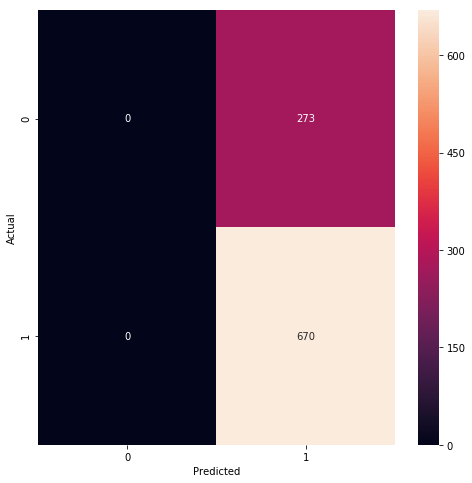

In [20]:
print(log_loss(Y, grid_lr.predict(X)))
conf_mat = confusion_matrix(Y, grid_lr.predict(X))

plt.figure(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

9.669612792776533


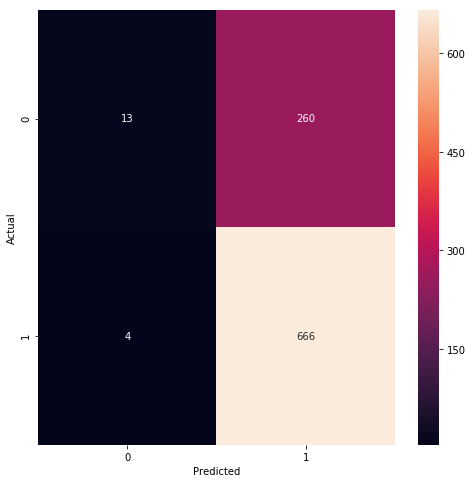

In [21]:
print(log_loss(Y, grid_svc.predict(X)))
conf_mat = confusion_matrix(Y, grid_svc.predict(X))

plt.figure(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

9.559734182397635


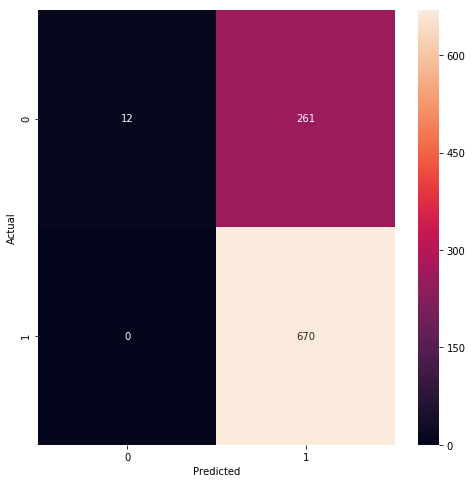

In [22]:
print(log_loss(Y, grid_rf.predict(X)))
conf_mat = confusion_matrix(Y, grid_rf.predict(X))

plt.figure(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

It seems that even after trying various good paramters we are not able to get good model whic fits data properly and properly predicts gender. It seems that our best `M3` model does not have enough information to predict gender properly.

It's little bit better than chance but not that good enough. I feel that its almost like chance only and shouldn't be used for prediction.